In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Binomial
from sklearn.linear_model import LogisticRegression
import math
from tqdm import tqdm

## Data Distributions

In [2]:
rho = 0.5
diff = 0.7
d = 2
muX_0 = torch.ones(d) * diff
muX_1 = -torch.ones(d) * diff

# def generate_distributions(a, b, a_, b_):
    
#     muZ_0 =  torch.ones(2) * math.sqrt(a) * math.sqrt(scale)
#     muZ_1 = -torch.ones(2) * math.sqrt(b) * math.sqrt(scale)

#     CZZ_0 = a * torch.eye(2)
#     CZX_0 = math.sqrt(scale) * torch.eye(2) * math.sqrt(a_) 
#     CZZ_1 = b * torch.eye(2)
#     CZX_1 = math.sqrt(scale) * torch.eye(2) * math.sqrt(b_)

#     return  muZ_0, muZ_1, CZZ_0, CZX_0, CZZ_1, CZX_1

def generate_distributions(a, b, a_, b_):
    
    muZ_0 = (a_ / a) * muX_0 / rho
    muZ_1 = (b_ / b) * muX_1 / rho

    CZZ_0 = a * torch.eye(d)
    CZX_0 = rho * torch.eye(d) * a_
    CZZ_1 = b * torch.eye(d)
    CZX_1 = rho * torch.eye(d) * b_

    CXX_0 = (1 + rho ** 2 * a) * torch.eye(d)
    CXX_1 = (1 + rho ** 2 * b) * torch.eye(d)

    return  muZ_0, muZ_1, CZZ_0, CZX_0, CZZ_1, CZX_1, CXX_0, CXX_1

## Utilities

In [3]:

def sample_Z_given(x, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, CXX_0, CXX_1, p, n_samples=10, seed=123):
    dist_0 = MultivariateNormal(loc=muZ_0 + CZX_0 @ torch.linalg.solve(CXX_0, x - muX_0), covariance_matrix=CZZ_0 - CZX_0 @ torch.linalg.solve(CXX_0, CXZ_0))
    dist_1 = MultivariateNormal(loc=muZ_1 + CZX_1 @ torch.linalg.solve(CXX_1, x - muX_1), covariance_matrix=CZZ_1 - CZX_1 @ torch.linalg.solve(CXX_1, CXZ_1))
    binom = Binomial(total_count=n_samples, probs=p)
    torch.manual_seed(seed)
    n1 = binom.sample((1,)).int().item()
    n0 = n_samples - n1
    return torch.cat([dist_0.rsample((n0,)), dist_1.rsample((n1,))], dim=0)

def compute_lpxz(x, z, mvn_0, mvn_1, p):
    v = torch.cat([x, z], axis=1)
    lp_1 = math.log(p)
    lp_0 = math.log(1 - p)
    numer = mvn_1.log_prob(v) + lp_1
    denom = torch.logsumexp(torch.stack([mvn_1.log_prob(v) + lp_1, mvn_0.log_prob(v) + lp_0]), dim=0)

    return numer - denom

def compute_lpz(z, mvnZ_0, mvnZ_1, p):
    lp_1 = math.log(p)
    lp_0 = math.log(1 - p)
    numer = mvnZ_1.log_prob(z) + lp_1
    denom = torch.logsumexp(torch.stack([mvnZ_1.log_prob(z) + lp_1, mvnZ_0.log_prob(z) + lp_0]), dim=0)
    return numer - denom

def compute_lpx(x, mvnX_0, mvnX_1, p):
    lp_1 = math.log(p)
    lp_0 = math.log(1 - p)
    numer = mvnX_1.log_prob(x) + lp_1
    denom = torch.logsumexp(torch.stack([mvnX_1.log_prob(x) + lp_1, mvnX_0.log_prob(x) + lp_0]), dim=0)
    return numer - denom

def compute_cmi(mvn_0, mvn_1, mvnZ_0, mvnZ_1, n_samples, p, tol=1e-8, seed=123):

    # compute test data
    torch.manual_seed(seed)
    n1 = int(n_samples * p)
    n0 = n_samples - n1
    v = torch.cat([mvn_0.rsample((n0,)), mvn_1.rsample((n1,))], dim=0)
    x = v[:, :len(muX_0)]
    z = v[:, len(muX_0):]
    v_ = torch.cat([mvn_0.rsample((n0,)), mvn_1.rsample((n1,))], dim=0)
    z_ =  v_[:, len(muX_0):]

    # pxz = torch.clamp(compute_lpxz(x, z, mvn_0, mvn_1, p), min=tol, max=1 - tol)
    # pz = torch.clamp(compute_lpz(z_, mvnZ_0, mvnZ_1, p), min=tol, max=1 - tol)
    lpxz = compute_lpxz(x, z, mvn_0, mvn_1, p)
    lpz = compute_lpz(z_, mvnZ_0, mvnZ_1, p)
    pxz = torch.exp(lpxz)
    pz = torch.exp(lpz)

    # possible numerical issue from exp then log.
    H_XZ = (-(pxz) * lpxz - (1 - pxz) * torch.log1p(-pxz)).mean()
    H_Z = (-(pz) * lpz - (1 - pz) * torch.log1p(-pz)).mean()

    return H_Z - H_XZ

def compute_bayes_accuracy(p, x, y, mvnX_0, mvnX_1):
    lpx = compute_lpx(x, mvnX_0, mvnX_1, p)
    y_pred = (lpx >= math.log(0.5)).int()
    return (y == y_pred).sum() / len(y)

def compute_two_stage_accuracy(p, x, y, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, CXX_0, CXX_1, mvnZ_0, mvnZ_1, seed=123):
    px = []
    for x_ in x:
        z = sample_Z_given(x_, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, CXX_0, CXX_1, p, n_samples=3000, seed=seed)
        px.append(torch.exp(compute_lpz(z, mvnZ_0, mvnZ_1, p)).mean())
    px = torch.tensor(px)
    y_pred = (px >= 0.5).int()
    return (y == y_pred).sum() / len(y)

In [4]:
def run_experiment(p, a, b, a_, b_, n_samples=10, seed=123):

    # data distributions and parametrs
    muZ_0,  muZ_1, CZZ_0, CZX_0, CZZ_1, CZX_1, CXX_0, CXX_1 = generate_distributions(a, b, a_, b_)
    CXZ_0 = CZX_0.T
    CXZ_1 = CZX_1.T
    mu_0 = torch.cat([muX_0, muZ_0])
    mu_1 = torch.cat([muX_1, muZ_1])
    C_0 = torch.cat(
            [
                torch.cat([CXX_0, CXZ_0], dim=1),
                torch.cat([CZX_0, CZZ_0], dim=1)
            ], dim=0
        )
    C_1 = torch.cat(
        [
            torch.cat([CXX_1, CXZ_1], dim=1),
            torch.cat([CZX_1, CZZ_1], dim=1)
        ], dim=0
    )

    # samplers
    mvn_0 = MultivariateNormal(loc=mu_0, covariance_matrix=C_0)
    mvn_1 = MultivariateNormal(loc=mu_1, covariance_matrix=C_1)

    mvnX_0 = MultivariateNormal(loc=muX_0, covariance_matrix=CXX_0)
    mvnX_1 = MultivariateNormal(loc=muX_1, covariance_matrix=CXX_1)

    mvnZ_0 = MultivariateNormal(loc=muZ_0, covariance_matrix=CZZ_0)
    mvnZ_1 = MultivariateNormal(loc=muZ_1, covariance_matrix=CZZ_1)

    # test for conditional independence of X and Y given Z
    muX_given_Z_0 = muX_0 - CXZ_0 @ torch.linalg.solve(CZZ_0, muZ_0)
    muX_given_Z_1 = muX_1 - CXZ_1 @ torch.linalg.solve(CZZ_1, muZ_1)
    print(f"\t conditional indep check first-order 1:  {torch.norm(muX_given_Z_0 - muX_given_Z_1).item():0.4f}")
    print(f"\t conditional indep check first-order 2:  {torch.norm(torch.linalg.solve(CZZ_0, CZX_0) - torch.linalg.solve(CZZ_1, CZX_1)).item():0.4f}")

    CXX_given_Z_0 = CXX_0 - CXZ_0 @ torch.linalg.solve(CZZ_0, CZX_0)
    CXX_given_Z_1 = CXX_1 - CXZ_1 @ torch.linalg.solve(CZZ_1, CZX_1)
    print(f"\t conditional indep check second-order: {torch.norm(CXX_given_Z_0 - CXX_given_Z_1).item():0.4f}")

    I = compute_cmi(mvn_0, mvn_1, mvnZ_0, mvnZ_1, 1000, p)

    # compute test data
    binom = Binomial(total_count=n_samples, probs=p)
    torch.manual_seed(seed)
    n1 = binom.sample((1,)).int().item()
    n0 = n_samples - n1
    x = torch.cat([mvnX_0.rsample((n0,)), mvnX_1.rsample((n1,))], dim=0)
    y = torch.cat([torch.zeros(n0), torch.ones(n1)]).int()

    acc1 = compute_bayes_accuracy(p, x, y, mvnX_0, mvnX_1)
    acc2 = compute_two_stage_accuracy(p, x, y, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, CXX_0, CXX_1, mvnZ_0, mvnZ_1)
    
    return I.item(), acc1.item(), acc2.item()

## Test Conditional Independence

In [5]:
p = 0.5
a = 5
b = 6

I, acc1, acc2 = run_experiment(p, a, b, a, b, n_samples=2000, seed=123)

print(f"I(X;Y|Z) = {I:0.8f}")
print(f"acc1 = {acc1:0.8f}")
print(f"acc2 = {acc2:0.8f}")

	 conditional indep check first-order 1:  0.0000
	 conditional indep check first-order 2:  0.0000
	 conditional indep check second-order: 0.0000
I(X;Y|Z) = 0.00334644
acc1 = 0.74949998
acc2 = 0.74949998


## Experiment

In [6]:
p = 0.5
a = 5
b = 6
props = torch.linspace(0.05, 1.0, 10)
# props = torch.logspace(-torch.inf, 0.0, 10)
# props = torch.tensor([0.0, 0.01, 0.03, 0.06, 0.6, 1.0])

Is, acc1s, acc2s = [], [], []
for prop in tqdm(props):
    print(f"control parameter = {prop:0.3f}")
    a_ = prop * a
    b_ = math.sqrt(prop) * b
    I, acc1, acc2 = run_experiment(p, a, b, a_, b_, n_samples=2000, seed=123)
    Is.append(I)
    acc1s.append(acc1)
    acc2s.append(acc2)
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

control parameter = 0.050
	 conditional indep check first-order 1:  1.9279
	 conditional indep check first-order 2:  0.1228
	 conditional indep check second-order: 0.2519


 10%|█         | 1/10 [00:04<00:40,  4.50s/it]


control parameter = 0.156
	 conditional indep check first-order 1:  1.8020
	 conditional indep check first-order 2:  0.1689
	 conditional indep check second-order: 0.0663


 20%|██        | 2/10 [00:08<00:35,  4.49s/it]


control parameter = 0.261
	 conditional indep check first-order 1:  1.6539
	 conditional indep check first-order 2:  0.1767
	 conditional indep check second-order: 0.0798


 30%|███       | 3/10 [00:13<00:31,  4.49s/it]


control parameter = 0.367
	 conditional indep check first-order 1:  1.4838
	 conditional indep check first-order 2:  0.1689
	 conditional indep check second-order: 0.1866


 40%|████      | 4/10 [00:18<00:27,  4.53s/it]


control parameter = 0.472
	 conditional indep check first-order 1:  1.2917
	 conditional indep check first-order 2:  0.1520
	 conditional indep check second-order: 0.2540


 50%|█████     | 5/10 [00:22<00:22,  4.55s/it]


control parameter = 0.578
	 conditional indep check first-order 1:  1.0775
	 conditional indep check first-order 2:  0.1289
	 conditional indep check second-order: 0.2820


 60%|██████    | 6/10 [00:27<00:18,  4.52s/it]


control parameter = 0.683
	 conditional indep check first-order 1:  0.8412
	 conditional indep check first-order 2:  0.1013
	 conditional indep check second-order: 0.2706


 70%|███████   | 7/10 [00:31<00:13,  4.50s/it]


control parameter = 0.789
	 conditional indep check first-order 1:  0.5828
	 conditional indep check first-order 2:  0.0702
	 conditional indep check second-order: 0.2198


 80%|████████  | 8/10 [00:36<00:09,  4.52s/it]


control parameter = 0.894
	 conditional indep check first-order 1:  0.3025
	 conditional indep check first-order 2:  0.0363
	 conditional indep check second-order: 0.1296


 90%|█████████ | 9/10 [00:40<00:04,  4.53s/it]


control parameter = 1.000
	 conditional indep check first-order 1:  0.0000
	 conditional indep check first-order 2:  0.0000
	 conditional indep check second-order: 0.0000


100%|██████████| 10/10 [00:45<00:00,  4.51s/it]

In [7]:
torch.save(torch.tensor(Is), f"output/mutual_info_{d}.pt")
torch.save(torch.tensor(acc1s), f"output/bayes_accuracies_{d}.pt")
torch.save(torch.tensor(acc2s), f"output/two_stage_accuracies_{d}.pt")
torch.save(props, f"output/props_{d}.pt")

## MiniCLIP Models

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [9]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_size, n_layers, out_features):
        super(MLP, self).__init__()
        if n_layers > 0:
            self.proj = nn.Linear(in_features, hidden_size)
            self.layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers - 1)])
            self.out = nn.Linear(hidden_size, out_features)
        else:
            self.out = nn.Linear(in_features, out_features)
        self.n_layers = n_layers

    def forward(self, x):
        if self.n_layers > 0:
            x = F.relu(self.proj(x))
            for layer in self.layers:
                x = F.relu(layer(x))
        return self.out(x)

def clip_loss(logits):
    cx   = F.log_softmax(logits, dim=1)
    cy   = F.log_softmax(logits, dim=0)
    return -torch.mean(0.5 * torch.diagonal(cx) + 0.5 * torch.diagonal(cy))

# reach goal
def vicreg_loss(logits):
    pass

def get_loss(loss):
    if loss == "clip":
        return clip_loss
    else:
        raise NotImplementedError

class MiniCLIP(nn.Module):
    def __init__(
            self,
            in_features_img, 
            hidden_size_img, 
            n_layers_img,
            in_features_txt, 
            hidden_size_txt, 
            n_layers_txt,
            out_features, 
            loss="clip",
        ):
        super(MiniCLIP, self).__init__()
        self.image_encoder = MLP(in_features_img, hidden_size_img, n_layers_img, out_features)
        self.text_encoder  = MLP(in_features_txt, hidden_size_txt, n_layers_txt, out_features)
        # self.logit_scale = torch.nn.Parameter(0.1 * torch.randn(1)) # learnable parameter
        self.scale = 100.
        self.loss = get_loss(loss)

    def forward(self, x, z):

        # extract feature representations of each modality
        I_f = self.image_encoder(x)
        T_f = self.text_encoder(z)

        # joint multimodal embedding [n, d_e]
        I_e = F.normalize(I_f)
        T_e = F.normalize(T_f)

        # scaled pairwise cosine similarities [n, n]
        logits = torch.matmul(I_e, T_e.T) * self.scale

        # symmetric loss function
        loss = self.loss(logits)

        return loss, logits

class MultimodalEmbeddingDataset(Dataset):
    def __init__(self, x, z, y):
        self.x = x
        self.z = z
        self.y = y
        self.n = len(self.x)

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        return i, self.x[i], self.z[i], self.y[i]

## Training Run

In [10]:
def run_nn_experiment(p, a, b, a_, b_, d, seed=123, device="cuda:0"):
    # data distributions and parametrs
    muZ_0,  muZ_1, CZZ_0, CZX_0, CZZ_1, CZX_1, CXX_0, CXX_1 = generate_distributions(a, b, a_, b_)
    CXZ_0 = CZX_0.T
    CXZ_1 = CZX_1.T
    mu_0 = torch.cat([muX_0, muZ_0])
    mu_1 = torch.cat([muX_1, muZ_1])
    C_0 = torch.cat(
            [
                torch.cat([CXX_0, CXZ_0], dim=1),
                torch.cat([CZX_0, CZZ_0], dim=1)
            ], dim=0
        )
    C_1 = torch.cat(
        [
            torch.cat([CXX_1, CXZ_1], dim=1),
            torch.cat([CZX_1, CZZ_1], dim=1)
        ], dim=0
    )

    # samplers
    mvn_0 = MultivariateNormal(loc=mu_0, covariance_matrix=C_0)
    mvn_1 = MultivariateNormal(loc=mu_1, covariance_matrix=C_1)


    torch.manual_seed(seed)

    # training data
    n_samples = 10000
    batch_size = 500
    n1 = int(n_samples * p)
    n0 = n_samples - n1
    v = torch.cat([mvn_0.rsample((n0,)), mvn_1.rsample((n1,))], dim=0)
    x = v[:, :len(muX_0)]
    z = v[:, len(muX_0):]
    y = torch.cat([torch.zeros(n0), torch.ones(n1)]).int()
    train_dataset = MultimodalEmbeddingDataset(x, z, y)
    train_dataloader = DataLoader(
        train_dataset, shuffle=True, batch_size=batch_size
    )

    # prompt data
    n_samples = 500
    n1 = int(n_samples * p)
    n0 = n_samples - n1
    v = torch.cat([mvn_0.rsample((n0,)), mvn_1.rsample((n1,))], dim=0)
    z0 = v[:n0, len(muX_0):]
    z1 = v[n0:, len(muX_0):]

    # evaluation data
    n_samples = 5000
    batch_size = 500
    n1 = int(n_samples * p)
    n0 = n_samples - n1
    v = torch.cat([mvn_0.rsample((n0,)), mvn_1.rsample((n1,))], dim=0)
    x = v[:, :len(muX_0)]
    z = v[:, len(muX_0):]
    y = torch.cat([torch.zeros(n0), torch.ones(n1)]).int()
    val_dataset = MultimodalEmbeddingDataset(x, z, y)
    val_dataloader = DataLoader(
        val_dataset, shuffle=True, batch_size=batch_size
    )

    model_cfg = {
        "in_features_img": d, 
        "hidden_size_img": 16, 
        "n_layers_img": 1,
        "in_features_txt": d, 
        "hidden_size_txt": 16, 
        "n_layers_txt": 1,
        "out_features": 2, 
    }
    model = MiniCLIP(**model_cfg).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

    n_epochs = 30
    for epoch in tqdm(range(n_epochs)):
        total_loss = 0
        for idx, x, z, y in train_dataloader:
            x = x.to(device)
            z = z.to(device)
            loss, logits = model(x, z)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        if epoch % 6 == 0:
            print(f"epoch {epoch + 1:02d}/{n_epochs:02d} loss: {total_loss / len(train_dataloader):0.5f}")

    # generate classifier
    with torch.no_grad():
        w0 = F.normalize(model.text_encoder(z0.to(device))).mean(dim=0)
        w1 = F.normalize(model.text_encoder(z1.to(device))).mean(dim=0)
        total_acc = 0
        for idx, x, z, y in val_dataloader:
            features = F.normalize(model.image_encoder(x.to(device)))
            scores = torch.stack([features @ w0, features @ w1])
            y_pred = torch.argmax(scores, dim=0).cpu()
            total_acc += ((y == y_pred).sum() / len(y)).item()
        avg_acc = total_acc / len(val_dataloader)

    return avg_acc

In [11]:
props = torch.load(f"output/props_{d}.pt")

acc3s = []
for prop in tqdm(props):
    print(f"control parameter = {prop:0.3f}")
    a_ = prop * a
    b_ = math.sqrt(prop) * b
    acc3 = run_nn_experiment(p, a, b, a_, b_, d, seed=567)
    acc3s.append(acc3)
    print(f"\t accuracy = {acc3:0.4f}")
    print()

torch.save(torch.tensor(acc3s), f"output/clip_accuracies_{d}.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

control parameter = 0.050


epoch 01/30 loss: 22.69090


epoch 07/30 loss: 6.21607


epoch 13/30 loss: 6.21029


epoch 19/30 loss: 6.20845


epoch 25/30 loss: 6.20739


 10%|█         | 1/10 [00:05<00:52,  5.89s/it]

	 accuracy = 0.7092

control parameter = 0.156


epoch 01/30 loss: 22.61258


epoch 07/30 loss: 6.19078


epoch 13/30 loss: 6.18260


epoch 19/30 loss: 6.17971


epoch 25/30 loss: 6.17754


 20%|██        | 2/10 [00:10<00:42,  5.30s/it]

	 accuracy = 0.7442

control parameter = 0.261


epoch 01/30 loss: 22.61045


epoch 07/30 loss: 6.15527


epoch 13/30 loss: 6.14569


epoch 19/30 loss: 6.14134


epoch 25/30 loss: 6.13848


 30%|███       | 3/10 [00:15<00:36,  5.14s/it]

	 accuracy = 0.7460

control parameter = 0.367


epoch 01/30 loss: 22.39768


epoch 07/30 loss: 6.11209


epoch 13/30 loss: 6.10035


epoch 19/30 loss: 6.09479


epoch 25/30 loss: 6.09166


 40%|████      | 4/10 [00:20<00:30,  5.01s/it]

	 accuracy = 0.7464

control parameter = 0.472


epoch 01/30 loss: 22.44750


epoch 07/30 loss: 6.05914


epoch 13/30 loss: 6.04670


epoch 19/30 loss: 6.04026


epoch 25/30 loss: 6.03688


 50%|█████     | 5/10 [00:25<00:25,  5.01s/it]

	 accuracy = 0.7450

control parameter = 0.578


epoch 01/30 loss: 21.81422


epoch 07/30 loss: 6.00699


epoch 13/30 loss: 5.98673


epoch 19/30 loss: 5.97781


epoch 25/30 loss: 5.97420


 60%|██████    | 6/10 [00:30<00:19,  4.93s/it]

	 accuracy = 0.7418

control parameter = 0.683


epoch 01/30 loss: 21.28830


epoch 07/30 loss: 5.95832


epoch 13/30 loss: 5.92171


epoch 19/30 loss: 5.91067


epoch 25/30 loss: 5.90601


 70%|███████   | 7/10 [00:35<00:14,  4.94s/it]

	 accuracy = 0.7424

control parameter = 0.789


epoch 01/30 loss: 20.93928


epoch 07/30 loss: 5.91179


epoch 13/30 loss: 5.85386


epoch 19/30 loss: 5.83915


epoch 25/30 loss: 5.83267


 80%|████████  | 8/10 [00:40<00:09,  4.91s/it]

	 accuracy = 0.7410

control parameter = 0.894


epoch 01/30 loss: 20.69702


epoch 07/30 loss: 5.86373


epoch 13/30 loss: 5.78111


epoch 19/30 loss: 5.75984


epoch 25/30 loss: 5.75058


 90%|█████████ | 9/10 [00:45<00:04,  4.94s/it]

	 accuracy = 0.7416

control parameter = 1.000


epoch 01/30 loss: 20.38393


epoch 07/30 loss: 5.76931


epoch 13/30 loss: 5.69539


epoch 19/30 loss: 5.66931


epoch 25/30 loss: 5.65839


100%|██████████| 10/10 [00:50<00:00,  5.01s/it]

	 accuracy = 0.7496



## Plotting

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 23
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 28
# mpl.rcParams['text.usetex'] = True # comment out this line if the machine does not have TeX installed
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
d = 2

Is = torch.load(f"output_backup/mutual_info_{d}.pt")
acc1s = torch.load(f"output_backup/bayes_accuracies_{d}.pt")
acc2s = torch.load(f"output_backup/two_stage_accuracies_{d}.pt")
acc3s = torch.load(f"output_backup/clip_accuracies_{d}.pt")
props = torch.load(f"output_backup/props_{d}.pt")

In [5]:
print(acc1s)
print(acc2s)
print(acc3s)
print(acc1s-acc2s)
print(Is)

tensor([0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495,
        0.7495])
tensor([0.7235, 0.7325, 0.7350, 0.7350, 0.7400, 0.7405, 0.7425, 0.7450, 0.7485,
        0.7495])
tensor([0.7092, 0.7442, 0.7460, 0.7464, 0.7450, 0.7418, 0.7424, 0.7410, 0.7416,
        0.7496])
tensor([0.0260, 0.0170, 0.0145, 0.0145, 0.0095, 0.0090, 0.0070, 0.0045, 0.0010,
        0.0000])
tensor([0.1713, 0.1557, 0.1355, 0.1131, 0.0897, 0.0664, 0.0443, 0.0248, 0.0099,
        0.0033])


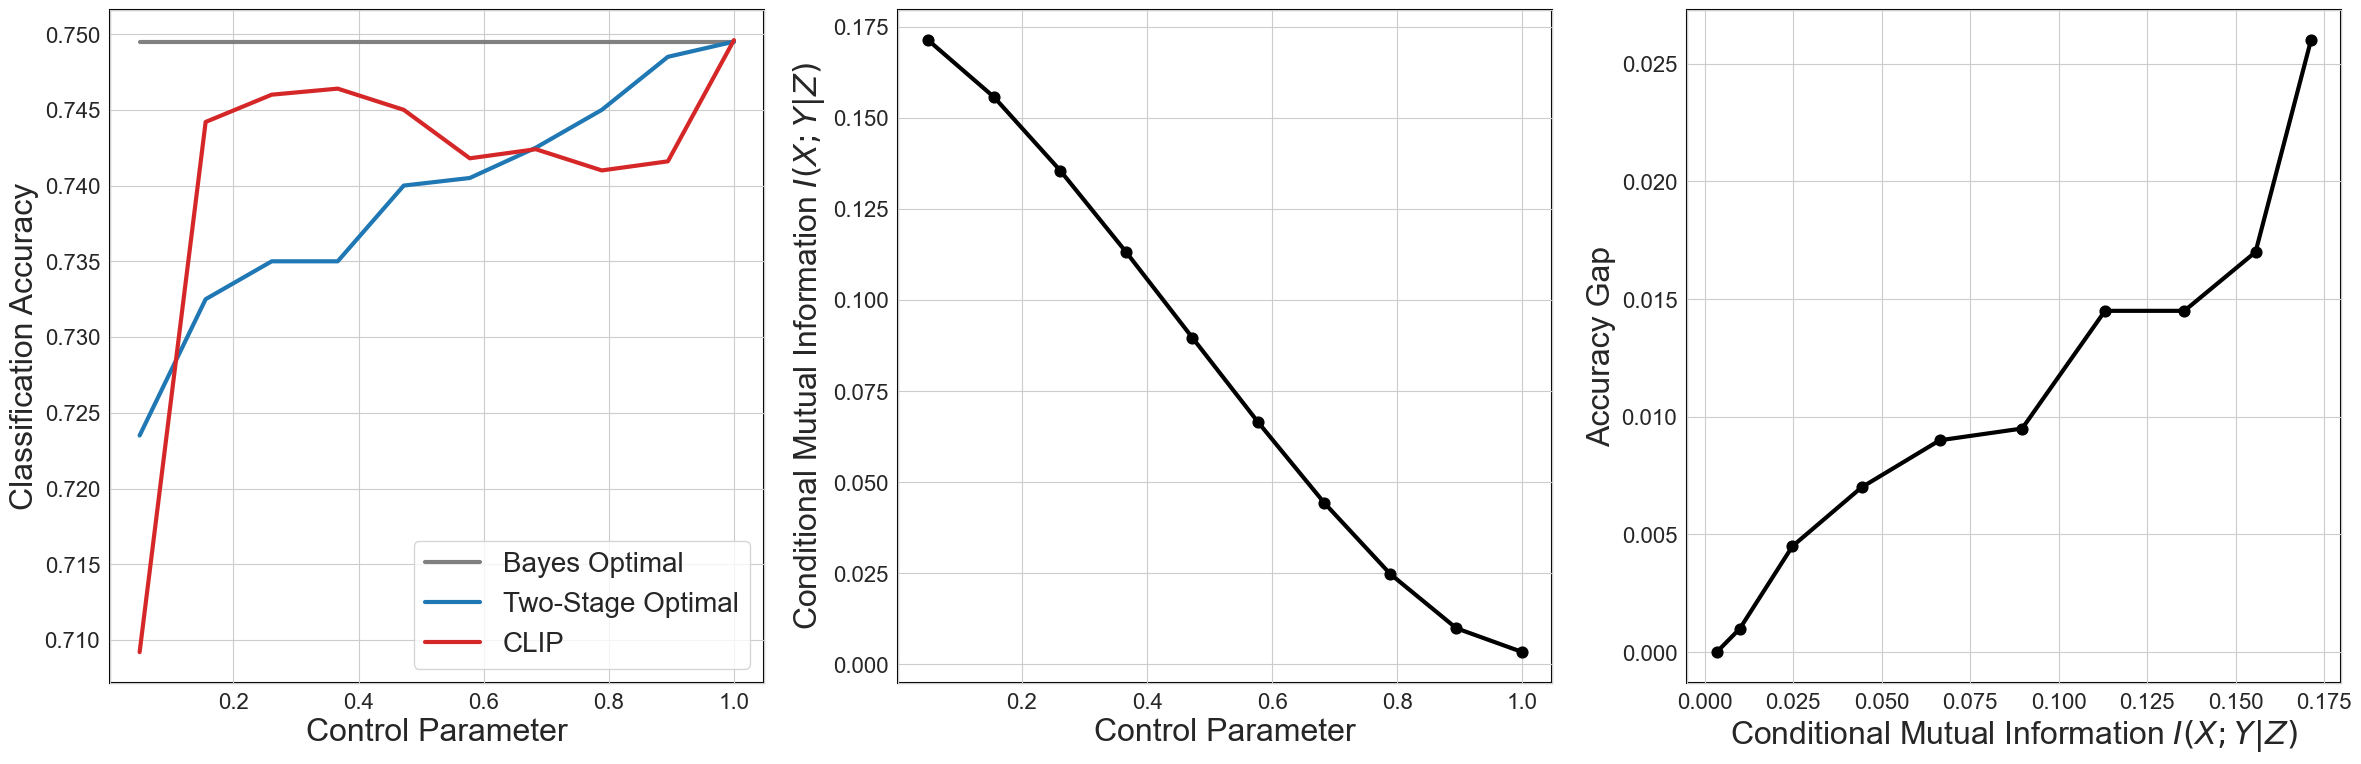

In [6]:
sns.set_style("whitegrid")

pscale = 8
s = 60
fig, ax = plt.subplots(1, 3, figsize=(3 * pscale, pscale))

points = props
ax[0].plot(points, acc1s, label="Bayes Optimal", color="gray")
ax[0].plot(points, acc2s, label="Two-Stage Optimal", color="tab:blue")
ax[0].plot(points, acc3s, label="CLIP", color="tab:red")
ax[0].legend(loc = "lower right")
ax[1].scatter(points, Is, color="k", s=s)
ax[1].plot(points, Is, color="k")

ax[0].set_ylabel("Classification Accuracy")
ax[1].set_ylabel(r"Conditional Mutual Information $I(X;Y|Z)$")

ax[0].set_xlabel("Control Parameter")
ax[1].set_xlabel("Control Parameter")

ax[2].scatter(Is, acc1s - acc2s, color="k", s=s)
ax[2].plot(Is, acc1s - acc2s, color="k")
ax[2].set_xlabel(r"Conditional Mutual Information $I(X;Y|Z)$")
ax[2].set_ylabel("Accuracy Gap")
# ax[2].set_xscale("log")
# ax[2].set_yscale("log")

for ax_ in ax:
    ax_.patch.set_edgecolor('black')  
    ax_.patch.set_linewidth(1.5)

fig.tight_layout(pad=2)